### Auto Encoder Creation
In this notebook we will be 
1. Select the non fraud records and train a simple auto encoder on top of it
2. Gather the reconstruction error for the entire dataset
3. Save the training and testing set with an additional field known as enc_field which will have the reconstruction error

In [35]:
import json
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import category_encoders as ce

print(f"{datetime.now()} AutoEncoder::Status - Training Script Init. Packages loaded")

# Package: autoencoder_pkg
class AutoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = self._build_autoencoder()

    def _build_autoencoder(self):
        model = Sequential()
        model.add(Input(shape=(self.input_dim,)))
        model.add(Dense(self.encoding_dim, activation='relu'))
        model.add(Dense(self.input_dim, activation='sigmoid'))
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y=None):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        self.autoencoder.fit(X, X, epochs=20, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping])
        return self

    def transform(self, X):
        return self.autoencoder.predict(X)

def train_pipeline(data, cat_cols, y):
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ce.OneHotEncoder(), cat_cols)
        ],
        remainder='passthrough'  # Numerical columns remain unchanged
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', MinMaxScaler()),
        ('autoencoder', AutoEncoder(input_dim=13))
    ])
    pipeline.fit(data, y)
    return pipeline

def predict(pipeline, data):
    return pipeline.transform(data)

def save_pipeline(pipeline, filename):
    joblib.dump(pipeline, filename)

def load_pipeline(filename):
    return joblib.load(filename)

def compute_mse(pipeline, data):
    # Transform the raw data using only the preprocessing steps
    transformed_data = pipeline.named_steps['preprocessor'].transform(data)
    transformed_data = pipeline.named_steps['scaler'].transform(transformed_data)
    
    # Get the autoencoder's predictions
    predictions = predict(pipeline, data)
    
    return mean_squared_error(transformed_data, predictions)

def mse_per_row(pipeline, data):
    # Transform the raw data using only the preprocessing steps
    transformed_data = pipeline.named_steps['preprocessor'].transform(data)
    transformed_data = pipeline.named_steps['scaler'].transform(transformed_data)
    #print(transformed_data[0])
    
    # Get the autoencoder's predictions
    predictions = predict(pipeline, data)
    
    # Compute squared differences
    squared_diffs = np.square(transformed_data - predictions)
    
    # Return mean squared error for each row
    return np.mean(squared_diffs, axis=1)

# Plotting Loss & Printing MSE
def plot_loss(autoencoder):
    plt.plot(autoencoder.autoencoder.history.history['loss'], label='Training Loss')
    plt.plot(autoencoder.autoencoder.history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.savefig('loss_plot')

def scatter_plot_1d(data1, data2=None, vline=None):
    # Create an array of indices for data1
    indices1 = range(len(data1))
    
    # Plot the data1
    plt.scatter(indices1, data1, color='blue', label='Good Transfers')
    
    # If data2 is provided, plot it as well
    if data2 is not None:
        indices2 = range(len(data2))
        plt.scatter(indices2, data2, color='red', label='Risky Transfers')
    
    # If vline value is provided, draw a vertical line at that x-axis value
    if vline is not None:
        plt.axhline(y=vline,color='yellow', linestyle='--', label='H-Line')
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Fraud vs good reconstruction error')
    plt.legend()
    plt.show()
    

print(f"{datetime.now()} AutoEncoder::Status - Functions defined.")

2023-10-09 17:39:46.792292 AutoEncoder::Status - Training Script Init. Packages loaded
2023-10-09 17:39:46.793227 AutoEncoder::Status - Functions defined.


In [4]:
df_train = pd.read_csv(f'training.csv')
print(f"{datetime.now()} AutoEncoder::Status - training data read.")
print(f'Train data size is {df_train.shape}')
print(f"Train data label distribution is {df_train['isFraud'].value_counts()}")

X = df_train[df_train['isFraud']!=1]
y = X['isFraud']
print(f"{datetime.now()} AutoEncoder::Status - training data processed.")
print(f'Train data size is {X.shape}')
cat_cols = ['step','type']

2023-10-09 17:24:30.143628 AutoEncoder::Status - training data read.
Train data size is (120731, 9)
Train data label distribution is isFraud
0    114982
1      5749
Name: count, dtype: int64
2023-10-09 17:24:30.147630 AutoEncoder::Status - training data processed.
Train data size is (114982, 9)


In [13]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,log_amount,isFraud
0,328,CASH_OUT,88667.37,5750.0,0.0,0.00,88667.37,11.392647,0
2,522,CASH_OUT,58486.02,7171.0,0.0,998052.15,1056538.17,10.976543,0
3,300,CASH_OUT,211581.92,1203.0,0.0,0.00,211581.92,12.262368,0
5,400,TRANSFER,277712.88,103637.0,0.0,277238.08,554950.96,12.534343,0
6,356,PAYMENT,3327.48,1260.0,0.0,0.00,0.00,8.109974,0


2023-10-09 17:32:48.713527 AutoEncoder::Status - training flow init.
Epoch 1/20
360/360 [==============================] - 0s 655us/step - loss: 0.0711 - val_loss: 0.0112
Epoch 2/20
360/360 [==============================] - 0s 554us/step - loss: 0.0057 - val_loss: 0.0030
Epoch 3/20
360/360 [==============================] - 0s 576us/step - loss: 0.0018 - val_loss: 9.9984e-04
Epoch 4/20
360/360 [==============================] - 0s 592us/step - loss: 7.4119e-04 - val_loss: 5.8561e-04
Epoch 5/20
360/360 [==============================] - 0s 553us/step - loss: 5.0465e-04 - val_loss: 4.4930e-04
Epoch 6/20
360/360 [==============================] - 0s 552us/step - loss: 3.9930e-04 - val_loss: 3.6380e-04
Epoch 7/20
360/360 [==============================] - 0s 560us/step - loss: 3.1918e-04 - val_loss: 2.8754e-04
Epoch 8/20
360/360 [==============================] - 0s 551us/step - loss: 2.4627e-04 - val_loss: 2.2109e-04
Epoch 9/20
360/360 [==============================] - 0s 552us/step - l

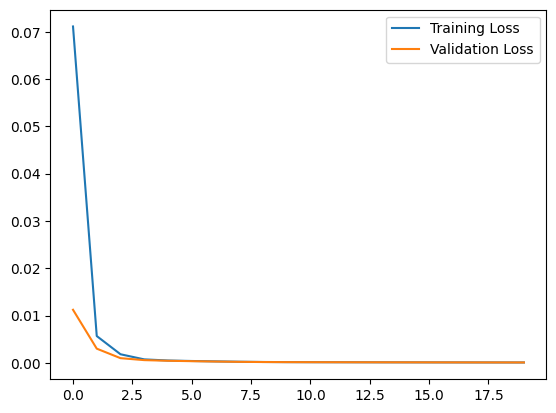

In [18]:
print(f"{datetime.now()} AutoEncoder::Status - training flow init.")

# Calling the function on a dataset
pipeline = train_pipeline(X, cat_cols,y)
plot_loss(pipeline.named_steps['autoencoder'])
print(f"{datetime.now()} AutoEncoder::Status - training complete MSE is.")
print("MSE:", compute_mse(pipeline, X))




In [19]:
print(f"{datetime.now()} AutoEncoder::Status - storing model.")
save_pipeline(pipeline, f'auto_encoder_pipeline_{datetime.now()}.pkl')

2023-10-09 17:33:31.165487 AutoEncoder::Status - storing model.


In [20]:
print(f"{datetime.now()} AutoEncoder::Status - storing error of every row of training set.")
arr=mse_per_row(pipeline, df_train)
df_train['enc_field']=arr
df_train.to_csv('train_with_enc_field.csv',index=False)
print(f"{datetime.now()} AutoEncoder::Status - Done created new training set with enc_filed")

2023-10-09 17:35:33.922776 AutoEncoder::Status - storing error of every row of training set.
3773/3773 [==============================] - 1s 235us/step
2023-10-09 17:35:35.777420 AutoEncoder::Status - Done created new training set with enc_filed


In [21]:
df_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,log_amount,isFraud,enc_field
0,328,CASH_OUT,88667.37,5750.00,0.0,0.00,88667.37,11.392647,0,0.000004
1,570,TRANSFER,9274.56,9274.56,0.0,0.00,0.00,9.135032,1,0.080647
2,522,CASH_OUT,58486.02,7171.00,0.0,998052.15,1056538.17,10.976543,0,0.000018
3,300,CASH_OUT,211581.92,1203.00,0.0,0.00,211581.92,12.262368,0,0.000008
4,405,CASH_OUT,973805.75,973805.75,0.0,0.00,973805.75,13.788967,1,0.079292


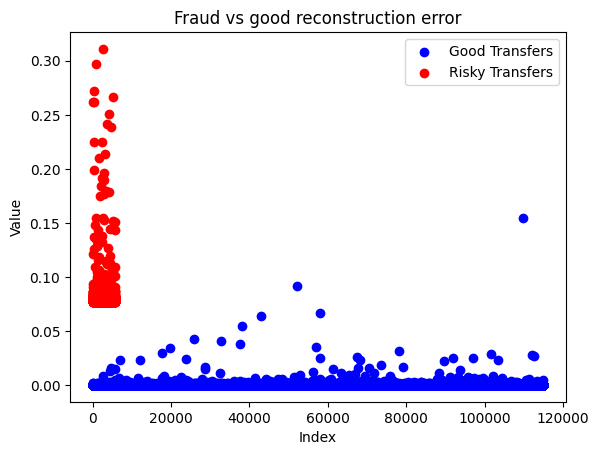

In [36]:
scatter_plot_1d(data1=df_train[df_train['isFraud']==0]['enc_field'],data2=df_train[df_train['isFraud']==1]['enc_field'])

In [37]:
df_test=pd.read_csv('testing.csv')
print(f"{datetime.now()} AutoEncoder::Status - storing error of every row of testing set.")
arr=mse_per_row(pipeline, df_test)
df_test['enc_field']=arr
df_test.to_csv('test_enc_field.csv',index=False)
print(f"{datetime.now()} AutoEncoder::Status - Done created new testing set with enc_filed")

2023-10-09 17:41:05.034196 AutoEncoder::Status - storing error of every row of testing set.
1617/1617 [==============================] - 0s 226us/step
2023-10-09 17:41:05.812229 AutoEncoder::Status - Done created new testing set with enc_filed


In [38]:
df_test.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,log_amount,isFraud,enc_field
0,205,CASH_OUT,128968.42,102281.00,0.00,0.00,128968.42,11.767323,0,0.000025
1,19,CASH_OUT,45207.78,0.00,0.00,1976709.27,2406907.94,10.719025,0,0.000220
2,229,PAYMENT,5123.81,10631.00,5507.19,0.00,0.00,8.541656,0,0.000019
3,229,CASH_IN,165746.30,5757131.19,5922877.49,594849.53,485214.27,12.018214,0,0.000065
4,300,PAYMENT,621.77,0.00,0.00,0.00,0.00,6.432586,0,0.000006
